<a href="https://colab.research.google.com/github/ComponentSoftTeam/Flan-T5-K8S-QA/blob/main/notebooks/q-lora-mistra-7b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q    ipywidgets==7.7.1 huggingface_hub tensorboard==2.14
!pip install -q -U fastapi kaleido python-multipart uvicorn Cython scipy
!pip install -q -U bitsandbytes matplotlib datasets torchvision
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U trl # Transformer Reinforcement Learning - For Finetuning using Supervised Fine-tuning
%load_ext tensorboard

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Config

In [6]:
class Config:
  def __init__(self):
    self.dataset = 'ComponentSoft/k8s-kubectl-cot-20k'
    self.base_model_id = 'mistralai/Mistral-7B-Instruct-v0.1'

    self.eval_percentile = 0.01
    self.max_token_length = 640

    self.lora_r = 16
    self.lora_alpha = 32
    self.lora_dropout = 0.05 # 0.01
    self.lora_bias = "none" # Will set to "all" for better quality but slower training
    self.lora_task_type = "CAUSAL_LM" # "SEQ_2_SEQ_LM"


    total_steps = 20
    dataset_size = 10_000 #19661

    self.batch_size = 30
    self.eval_batch_size = 2
    self.train_steps = (dataset_size // self.batch_size)
    self.warmup_steps = int(self.train_steps * 0.1)
    self.gradient_accumulation_steps = 1
    self.learning_rate = 2e-4
    self.use_bf16 = True
    self.weight_decay = 0.001

    self.checkpoint_step = self.train_steps // total_steps

    self.response_template = "### Answer:"

  def format_prompt(self, prompt):
    return f'[INST] {prompt[0].strip()}\n Lets think step by step. [/INST] {self.response_template}\n# Steps: {prompt[1]}\n # Command: {prompt[2]} #End'

  def transform_dataset(self, dataset):
    """ Transform a dataset from dict of lists into list of tuples """
    return list(zip(dataset['question'], dataset['chain_of_thought'], dataset['command']))

config = Config()

# Utility

In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
# from google.colab import output
from huggingface_hub import notebook_login

notebook_login()
# output.enable_custom_widget_manager()

In [19]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer


def plot_data_lengths(train_dataset, eval_dataset):
    """ Check the distribution of the lengths of the tokenized prompts """

    tokenizer = AutoTokenizer.from_pretrained(
        config.base_model_id,
        padding_side="right",
        add_eos_token=True,
        add_bos_token=True,
    )
    tokenizer.pad_token = tokenizer.eos_token

    def tokenize_prompt_wo_pad(prompt):
        return tokenizer(prompt['prompt'])

    tokenized_train_dataset = train_dataset.map(tokenize_prompt_wo_pad)
    tokenized_eval_dataset = eval_dataset.map(tokenize_prompt_wo_pad)

    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_eval_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

In [3]:
from transformers import AutoTokenizer

def test_model(model, prompt):
  tokenizer = AutoTokenizer.from_pretrained(
      config.base_model_id,
      add_bos_token=True,
  )

  model_input = tokenizer(prompt, return_tensors="pt").to("cuda")

  model.eval() # switches the model into evaluation mode, disables things like dropout
  with torch.no_grad():
    response = tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True)

  return response

In [4]:
def print_stats(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# Prepare the dataset

In [7]:
from transformers import AutoTokenizer

# Add the begin and end sequence tokens
tokenizer = AutoTokenizer.from_pretrained(
    config.base_model_id,
    padding_side="right",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [17]:
from datasets import load_dataset, Dataset

dataset = load_dataset(config.dataset, split="train")
train_dataset, eval_dataset = dataset.train_test_split(test_size=config.eval_percentile).values()

train_dataset = config.transform_dataset(train_dataset)
eval_dataset = config.transform_dataset(eval_dataset)

train_dataset = [*map(config.format_prompt, train_dataset)]
eval_dataset = [*map(config.format_prompt, eval_dataset)]

train_dataset = Dataset.from_dict({"prompt": train_dataset})
eval_dataset = Dataset.from_dict({"prompt": eval_dataset})

print(f'Train: {len(train_dataset)} to eval: {len(eval_dataset)}')

Train: 19464 to eval: 197


In [9]:
# The <s> and </s> are tokens wrapping a logical unit of the context, it ususally consist of instruction - answer pairs
# The [INST] and [/INST] token wraps an instruction
# Read more: https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1
def log_tokenized(*texts):
    l = max(len(text) for text in texts)

    print("Tokenized")
    print('\n'.join(f'{text.ljust(l)}:{tokenizer(text).input_ids}' for text in texts))
    print("\nPartialy decoded")
    print('\n'.join(f'{text.ljust(l)}:{tokenizer.decode(tokenizer(text).input_ids, skip_special_tokens = True)}' for text in texts))

log_tokenized(
  "hey",
  "<s> hey </s>",
  "[ INST ] hey",
  "[INST] hey",
  "[INST] hey [/INST]",
)

print("\n")
tokenizer

Tokenized
hey               :[1, 28139, 2]
<s> hey </s>      :[1, 1, 28705, 28139, 28705, 2, 2]
[ INST ] hey      :[1, 733, 2693, 920, 4709, 28139, 2]
[INST] hey        :[1, 733, 16289, 28793, 28139, 2]
[INST] hey [/INST]:[1, 733, 16289, 28793, 28139, 733, 28748, 16289, 28793, 2]

Partialy decoded
hey               :hey
<s> hey </s>      : hey 
[ INST ] hey      :[ INST ] hey
[INST] hey        :[INST] hey
[INST] hey [/INST]:[INST] hey [/INST]




LlamaTokenizerFast(name_or_path='mistralai/Mistral-7B-Instruct-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Map:   0%|          | 0/19464 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

19661


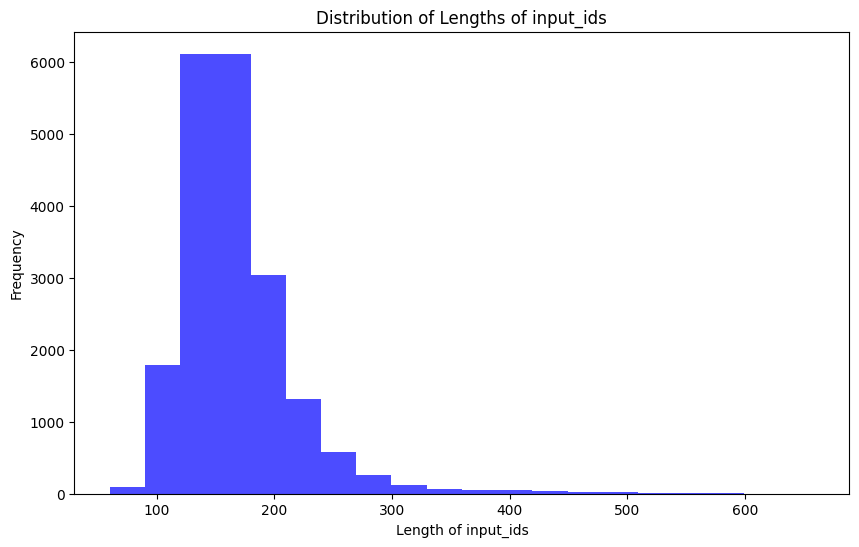

In [20]:
# plot_data_lengths(train_dataset, eval_dataset)

# Setting PEFT configuration

## Quantization

In [11]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# About the terminology and the parameters: https://aisuko.gitbook.io/wiki/ai-techniques/training/training-with-qlora
bnb_config = BitsAndBytesConfig(
    # Blogpost about LLama 2 7b inference speed https://openmmlab.medium.com/faster-and-more-efficient-4-bit-quantized-llm-model-inference-a27d35a66c29
    # Research paper about k bit quantization inference https://arxiv.org/pdf/2212.09720.pdf
    # The conclusion is if the quantized nodes are frozen 4 bit quantization is the best
    load_in_4bit=True,

    # The name of the technique proposed by the same qlora paper
    bnb_4bit_use_double_quant=True,

    # Use the "normal float" quantization
    bnb_4bit_quant_type="nf4",

    # The datatype that is used during algebratic operations
    bnb_4bit_compute_dtype=torch.bfloat16
)

## LoRA

In [12]:
from peft import LoraConfig, get_peft_model


lora_config = LoraConfig(
    # A very detailed comperison of different r and alpha values: https://github.com/cloneofsimo/lora/discussions/37
    r=config.lora_r,
    lora_alpha=config.lora_alpha,

    # The targeted matrixes for LoRA are taken from: https://brev.dev/blog/fine-tuning-mistral-your-own-data#4-set-up-lo-ra
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],

    bias=config.lora_bias,
    lora_dropout=config.lora_dropout,
    task_type=config.lora_task_type,
)


## Apply the configurations to the model

In [13]:
from peft import prepare_model_for_kbit_training

# Caching shouldn't be used while training but
# Gives an O(n^2) inference complexity instead of O(n^3)
# at inference, by the number of generated tokens
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_id,
    use_cache=False,
    quantization_config=bnb_config,
)

# Gradient checkpointing: https://residentmario.github.io/pytorch-training-performance-guide/gradient-checkpoints.html
# TLDR a memory / speet tradeof: https://residentmario.github.io/pytorch-training-performance-guide/gradient-checkpoints.html#benchmarks
model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant":True})

# Prepares the model for kbit training by doing the following:
# Cast the layernorm in fp32
# Making output embedding layer require grads
# Add the upcasting of the lm head to fp32
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 42,520,576 || all params: 7,284,252,672 || trainable%: 0.583732853796316


## Configure training

In [14]:
from transformers import TrainingArguments

#IDK
# tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

training_args = TrainingArguments(
    # Directory to put data to
    output_dir='output',

    # the number of steps in the training, where
    # each step is an evluation of a batch
    max_steps=config.train_steps,

    # the number of steps with small, and increasing learning rate
    # in the end the target learning rate is hit, after that the
    # learning rate scheduler takes over
    # this allows the adaptive optimizer to gather statistics
    # and smooths out the start
    warmup_steps=config.warmup_steps,

    # the size of each batch, its optimal to tune it to fill up the available memory
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.eval_batch_size,
    # if there isn't enought memory for a large enought batch size for
    # batch normalization, then you can set this to signal the trainer
    # to only do the back propagation after k steps, this simulates
    # the behaviour of a larger batch size, but it is slower
    gradient_accumulation_steps=config.gradient_accumulation_steps,

    # The "starting" learning rate, after warmup
    learning_rate=config.learning_rate,

    # use bf 16 if possible (only on A100 or other Ampere seriese gpus)
    # read about it https://en.wikipedia.org/wiki/Bfloat16_floating-point_format
    bf16=config.use_bf16,
    fp16=not config.use_bf16,

    # Paging the optimizers data to allow for larger models
    # Using adamw to allow for weight decay, to prevent overfitting
    # Use 32 bit floating point for internal calculations, paged_adamw_8bit also exists
    # During training the intermediate activation values and the gradients (if gradient checkpointing is not set)
    # are using the 16 bf or fp datatype
    # The optimizers states, such as moving averages, momentum etc, and the calculation of the loss function
    # and the gradiant accumulation if performed in 32 bit
    optim="paged_adamw_32bit",

    # provides regularization, and prevents the lower range bf16 numbers form projecting into
    # not representable numbers, read more: https://arxiv.org/pdf/2310.04415.pdfl
    # the paper proposes 0.1 as a good generay starting point
    weight_decay=config.weight_decay,

    # Directory for storing logs
    logging_dir="./logs",
    logging_steps=config.checkpoint_step,

    # Save the model checkpoint every logging step
    save_strategy="steps",
    save_steps=config.checkpoint_step,

    # Evaluate the model every logging step
    evaluation_strategy="steps",
    eval_steps=config.checkpoint_step,

    # Perform evaluation at the end of training
    do_eval=True,

    report_to="tensorboard",
)



In [15]:
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from datasets import Dataset

# docs for the trainer: https://huggingface.co/docs/trl/main/en/sft_trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="prompt",
    args=training_args,
    data_collator=DataCollatorForCompletionOnlyLM(config.response_template, tokenizer=tokenizer),
    packing=False,
    tokenizer=tokenizer,
    max_seq_length=config.max_token_length,
)


Map:   0%|          | 0/19464 [00:00<?, ? examples/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

# Training

## Train

In [16]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
16,1.073800,0.535789
32,0.460500,0.383555
48,0.369700,0.328586
64,0.333100,0.301694
80,0.310100,0.284726
96,0.295900,0.279458
112,0.280300,0.272108
128,0.264900,0.265898
144,0.278900,0.260791
160,0.276600,0.253533


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=333, training_loss=0.31696638044294295, metrics={'train_runtime': 1954.1664, 'train_samples_per_second': 5.112, 'train_steps_per_second': 0.17, 'total_flos': 1.365406279852032e+17, 'train_loss': 0.31696638044294295, 'epoch': 0.51})

## Metrics

In [ ]:
%tensorboard --logdir logs

## Test

In [79]:
import torch
from transformers.generation.stopping_criteria import StoppingCriteria, StoppingCriteriaList
import torch

model.eval()
model.use_cache=True
tokenizer.add_eos_token = False
tokenizer.add_bos_token = True
tokenizer.pad_token = None

stop_terms=["</s>", "#End"]
eos_token_ids_custom =  [torch.tensor(tokenizer.encode(term, add_special_tokens=False)).to("cuda") for term in stop_terms]

class DummyStopCriterion(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, score: torch.FloatTensor, **kwargs):
        return any(torch.equal(e, input_ids[0][-len(e):]) for e in eos_token_ids_custom)

def test_model(prompt):

    model_input = tokenizer(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
      response = tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15, stopping_criteria=StoppingCriteriaList([DummyStopCriterion()]))[0], skip_special_tokens=True)

    start_template = '### Answer:'
    command_template = '# Command:'
    end_template = '#End'

    if start_template in response:
        start = response.index(start_template) + len(start_template)
    else:
        start = len(prompt)

    start = response.index(command_template) + len(command_template) if command_template in response else start
    end = response.index(end_template) if end_template in response else 0

    true_response = response[start:end].strip()

    print(f"Deleted {len(response) - len(end_template) - end} chars after: \"{response[end + len(end_template):]}\"")
    print(f'the original output: {response}')
    return true_response

In [65]:
tokenizer("\n# Steps: 1. use the").input_ids

[1, 28705, 13, 28771, 2349, 782, 28747, 28705, 28740, 28723, 938, 272]

In [66]:
test_model(f'[INST] Scale a Kubernetes Deployment named "my-app" to 5 replicas.\n Lets think step by step. [/INST] {config.response_template}')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 0 chars after: ""


'kubectl scale --replicas=5 deployment/my-app'

In [80]:
test_model("[INST] what is the capital of Hungary [/INST]")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 82 chars after: "T] what is the capital of Hungary [/INST] The capital city of Hungary is Budapest."
the original output: [INST] what is the capital of Hungary [/INST] The capital city of Hungary is Budapest.


''

In [69]:
test_model("[INST] list all pods with the label prod [/INST]")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 438 chars after: "T] list all pods with the label prod [/INST] To list all pods with a specific label, you can use the `kubectl get` command with the `-l` flag to specify the label selector. In this case, the label selector would be `prod`, which means it will select all pods that have the label `prod`.

Here's an example command:
```bash
kubectl get pods -l prod
```
This command will return a list of all pods in the cluster that have the label `prod`."


''

In [70]:
test_model(f'[INST] Generate a Kubernetes ConfigMap named "my-config" with key-value pairs for configuration data.\n Lets think step by step. [/INST] {config.response_template}')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 0 chars after: ""


'kubectl create configmap my-config --from-literal=conf=/path/to/profiles/file1.txt --from-literal=data=secretkey123'

In [71]:
test_model(f'[INST] Roll back a Kubernetes Deployment named "my-app" to the previous version.\n Lets think step by step. [/INST] {config.response_template}')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 0 chars after: ""


'kubectl rollout undo deployment/my-app --to-revision=0'

In [72]:
test_model(f'[INST] Remove a Kubernetes namespace named "my-namespace" along with all its resources.\n Lets think step by step. [/INST] {config.response_template}')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 0 chars after: ""


'kubectl delete namespace my-namespace'

In [73]:
test_model(f'[INST] List all pods in the "my-namespace" with the label "environment=production".\n Lets think step by step. [/INST] {config.response_template}')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 0 chars after: ""


'kubectl get pods -l environment=production,namespace=my-namespace'

In [74]:
test_model(f'[INST] Create a Kubernetes Service to expose a Deployment named "my-service" using a LoadBalancer.\n Lets think step by step. [/INST] {config.response_template}')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 0 chars after: ""


'kubectl create service loadbalancer my-service --tcp=8089:http'

In [75]:
test_model(f'[INST] Set CPU and memory resource limits on a pod named "my-pod" to 0.5 CPU and 512Mi memory.\n Lets think step by step. [/INST] {config.response_template}')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 0 chars after: ""


'kubectl set resources pod my-pod --limits=cpu=0.5,memory=512Mi'

In [76]:
test_model(f'[INST] Display a list of all nodes in the Kubernetes cluster along with their status.\n Lets think step by step. [/INST] {config.response_template}')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 0 chars after: ""


'kubectl get nodes --all --output=json'

In [78]:
test_model(f'[INST] Apply a Network Policy to restrict network communication for pods labeled "app=my-app".\n Lets think step by step. [/INST] {config.response_template}')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Deleted 0 chars after: ""


'kubectl apply -f https://raw.githubusercontent.com/kubernetes-samples/node-problem/master/network-policy-example/app-network-policy.yaml --selector=app=my-app --ingress-rule="10.19.21.22=tcp"'

## Upload

In [81]:
model.push_to_hub('ComponentSoft/mistral-kubectl-instruct')
tokenizer.push_to_hub('ComponentSoft/mistral-kubectl-instruct')

adapter_model.bin:   0%|          | 0.00/170M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ComponentSoft/mistral-kubectl-instruct/commit/383c1a1788e4c05f0da84f19da4e6fb71b1a289f', commit_message='Upload tokenizer', commit_description='', oid='383c1a1788e4c05f0da84f19da4e6fb71b1a289f', pr_url=None, pr_revision=None, pr_num=None)